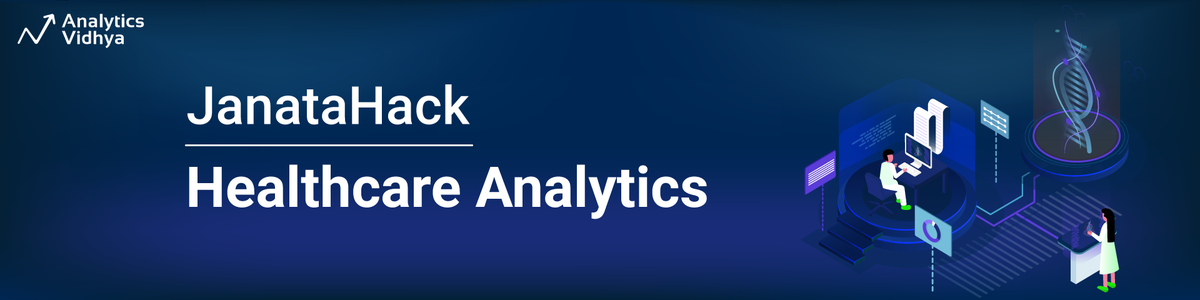

   *  **Public LB rank     :   23**
   *  **Private LB rank    :   24**
   
   **Link to Leaderboard  :  http://datahack.analyticsvidhya.com/contest/janatahack-healthcare-analytics-ii/#LeaderBoard**

# Problem Statement : Janatahack: Healthcare Analytics II

*Recent Covid-19 Pandemic has raised alarms over one of the most overlooked area to focus: Healthcare Management. While healthcare management has various use cases for using data science, patient length of stay is one critical parameter to observe and predict if one wants to improve the efficiency of the healthcare management in a hospital.*[](http://)

*This parameter helps hospitals to identify patients of high LOS risk (patients who will stay longer) at the time of admission. Once identified, patients with high LOS risk can have their treatment plan optimized to miminize LOS and lower the chance of staff/visitor infection. Also, prior knowledge of LOS can aid in logistics such as room and bed allocation planning.*

*Suppose you have been hired as Data Scientist of HealthMan – a not for profit organization dedicated to manage the functioning of Hospitals in a professional and optimal manner. The task is to accurately predict the Length of Stay for each patient on case by case basis so that the Hospitals can use this information for optimal resource allocation and better functioning. The length of stay is divided into 11 different classes ranging from 0-10 days to more than 100 days.*

In [ ]:
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


 # Library imports

In [ ]:
import lightgbm as lgb
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn import preprocessing
from sklearn.metrics import accuracy_score
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns 
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score

# Dataset

In [ ]:
train = pd.read_csv("../input/av-healthcare2/train.csv")
test =  pd.read_csv("../input/av-healthcare2/test.csv")
sample_sub =  pd.read_csv("../input/av-healthcare2/sample_submission.csv")
desc =  pd.read_csv("../input/av-healthcare2/train_data_dict.csv")
test_copy = test

In [ ]:
train.head(2).append(train.head(2))

# Missing value imputation

In [ ]:
train['Bed Grade'] = train['Bed Grade'].fillna(method="ffill",axis=0)
train['City_Code_Patient'] = train['City_Code_Patient'].fillna(method="ffill",axis=0)      #filling missing values with forward fill

test['Bed Grade'] = test['Bed Grade'].fillna(method="ffill",axis=0)
test['City_Code_Patient'] = test['City_Code_Patient'].fillna(method="ffill",axis=0)

train['Bed Grade'] = train['Bed Grade'].astype(np.int64)                                  # Converting object to int type
test['City_Code_Patient'] = test['City_Code_Patient'].astype(np.int64)

In [ ]:
# Combining train and test data for preprocessing 

train['is_train'] = 1
test['is_train'] = 0
test['Stay'] = None
print(train.shape, test.shape)


# Encoding Categorical variables

In [ ]:
#!pip install category_encoders

import category_encoders as ce

df_data = pd.concat((train,test))

encoder = ce.OrdinalEncoder(return_df = True)
df_data['Ward_Facility_Code'] = encoder.fit_transform(df_data['Ward_Facility_Code'])        # Using ordinal encoders to encode categorical variables 
  
encoder = ce.OrdinalEncoder(return_df = True)
df_data['Type of Admission'] = encoder.fit_transform(df_data['Type of Admission'])

encoder = ce.OrdinalEncoder(return_df = True)
df_data['Severity of Illness'] = encoder.fit_transform(df_data['Severity of Illness'])

In [ ]:
# Encoding age feature

val = { '0-10':1, '11-20': 2,'21-30':3,'31-40':4,'41-50':5,'51-60':6,'61-70':7,'71-80':8,'81-90':9,'91-100':10   }
df_data['Age'] = df_data['Age'].map(val)
df_data['Age'].value_counts()

In [ ]:
# Creating age bins using Age feature

val1 = { 1:'Young', 2: 'Young',3:'Adult',4:'Adult',5:'Adult',6:'Aged',7:'Aged',8:'Aged',9:'Aged',10:'Aged'   }
df_data['Age_group'] = df_data['Age'].map(val1)

df_data['Age_group'].value_counts()

In [ ]:
ob_col = df_data.select_dtypes(['object']).columns.tolist()   # Selecting object features for label encoding 

ob_col.remove("Stay")
le = preprocessing.LabelEncoder() 

for col in ob_col:
    df_data[col] = le.fit_transform(df_data[col])

df_data.head(2)

In [ ]:

cat=test_copy.select_dtypes(['object']).columns.tolist()
cat.append('Age_group')
cat

# Feature creation

In [ ]:
df_data['Unique_hosp_per_patient']=df_data.groupby(['patientid'])['Hospital_code'].transform('nunique') 
df_data['Unique_patitent_per_hosp']=df_data.groupby(['Hospital_code'])['patientid'].transform('nunique') 
df_data['hosp_per_city']=df_data.groupby(['City_Code_Hospital'])['Hospital_code'].transform('nunique') 
df_data['total_hosp_city_same_type']=df_data.groupby(['City_Code_Hospital'])['Hospital_type_code'].transform('nunique') 
df_data['Ward_Type_Severity of Illness'] = df_data.groupby(['Ward_Type','Severity of Illness'])['patientid'].transform('nunique')
df_data['Unique_dept_per_patient']=df_data.groupby(['patientid'])['Department'].transform('nunique') 
df_data['Severity of Illness_dept'] = df_data.groupby(['Severity of Illness','Department'])['patientid'].transform('nunique')
df_data['Severity of Illness_age_grp'] = df_data.groupby(['Severity of Illness','Age_group'])['patientid'].transform('nunique')
df_data['hos_vis_diffcity'] = df_data.groupby('patientid')['City_Code_Hospital'].transform('nunique') 


In [ ]:
df_data['visit_same_hos_type'] = df_data.groupby('patientid')['Hospital_type_code'].transform('count') 
df_data['Severity of Illness_age'] = df_data.groupby(['Severity of Illness','Age'])['patientid'].transform('count')
df_data['total_cases_per_patient'] = df_data.groupby('patientid')['case_id'].transform('count')
df_data['visit_same_hos'] = df_data.groupby('Hospital_code')['patientid'].transform('count') 
df_data['freq_patients'] = df_data.groupby('patientid')['patientid'].transform('count') 
df_data['visit_same_dep_type'] = df_data.groupby('patientid')['Department'].transform('count') 


In [ ]:
df_data['mean_admission'] = df_data.groupby('patientid')['Admission_Deposit'].transform('mean') 
df_data['bill_per_patitent']=df_data.groupby(['patientid'])['Admission_Deposit'].transform('sum') 
df_data['median_admission'] = df_data.groupby('patientid')['Admission_Deposit'].transform('median') 
df_data['min_Severity of Illness_pat'] = df_data.groupby('patientid')['Severity of Illness'].transform('min')
df_data['max_Severity of Illness_pat'] = df_data.groupby('patientid')['Severity of Illness'].transform('max')
df_data['max_bed_pat'] = df_data.groupby(['patientid'])['Bed Grade'].transform('max')
df_data['max_vis_pat'] = df_data.groupby(['patientid'])['Visitors with Patient'].transform('max')


df_data.isnull().sum()


In [ ]:
df_data['Age_group'] = df_data['Age_group'].astype("int64")


df_train, df_test = df_data[df_data.is_train == 1], df_data[df_data.is_train == 0]
df_train.drop(['is_train'], inplace=True, axis=1)                   # Splitting back train and set sets 
df_test.drop(['is_train'], inplace=True, axis=1)
df_test.drop(['Stay'], inplace=True, axis=1)

le = preprocessing.LabelEncoder()
df_train['Stay'] = le.fit_transform(df_train['Stay'])

df_train['Stay'] = df_train['Stay'].astype(int)

In [ ]:
corr_m = df_train.corr()                                # Checking correlation between target and features 
corr_m['Stay'].sort_values(ascending = True)

# Splitting data for training the model

In [ ]:

X = df_train.drop(['Stay','case_id','patientid'],axis=1)
y = df_train['Stay']

X_train, X_test, y_train,y_test = train_test_split(X, y, test_size=0.30, random_state=42, shuffle=True, stratify=df_train['Stay'])



In [ ]:
feature_cols = df_train.columns.tolist()
feature_cols.remove('Stay')
feature_cols.remove('case_id')
feature_cols.remove('patientid')


label_col = 'Stay'
print("Feature cols")
print(" ")
print(feature_cols)
print(" ")
print('Catagorical columns')
print(" ")
cat_cols = cat
print(cat_cols)

In [ ]:
# Parameters used for Light GBM model

params = {}
params['learning_rate'] = 0.06
params['max_depth'] = 50
params['n_estimators'] = 500
params['objective'] = 'multiclass'
params['boosting_type'] = 'gbdt'
params['subsample'] = 0.7
params['random_state'] = 42
params['colsample_bytree']=0.7
params['min_data_in_leaf'] = 55
params['reg_alpha'] = 1.6
params['reg_lambda'] = 1.1

# Light GBM Model

In [ ]:
clf = lgb.LGBMClassifier( **params ,n_jobs = -1, is_unbalanced = True)

clf.fit(X_train, y_train, eval_metric='multi_error', verbose=False)

eval_score_acc = accuracy_score(y_test, clf.predict(X_test))

print('ACC: {}'.format(eval_score_acc))

In [ ]:
# Training the model and checking with 5 fold cv

clf = lgb.LGBMClassifier(**params,n_jobs= -1)
score = cross_val_score(clf , X_train, y_train , cv = 5 , n_jobs = -1,verbose = 1 )
score

In [ ]:
# Training model with whole dataset

clf = lgb.LGBMClassifier( **params ,n_jobs = -1, is_unbalanced = True, )

clf.fit(X, y, eval_metric='multi_error', verbose=False)

df_test = df_test.drop(['case_id','patientid'],axis=1)
lgbm= clf.predict_proba(df_test)

In [ ]:
plt.rcParams['figure.figsize'] = (12,8)
lgb.plot_importance(clf)
plt.show() 

 # Feature selection 

In [ ]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

bestfeatures = SelectKBest(score_func=chi2,k=20)
fit = bestfeatures.fit(X,y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)

featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Features','Score']
featureScores['Score'] = round(featureScores['Score'],2)
featureScores.sort_values(by = 'Score', ascending= False)


# Catboost model

In [ ]:
#!pip install catboost

from catboost import CatBoostClassifier


In [ ]:
cb = CatBoostClassifier(loss_function = 'MultiClass', objective= 'MultiClass',learning_rate = 0.09,
                        eval_metric = 'Accuracy', early_stopping_rounds=20 )

#cb.fit(X_train,y_train )

score = cross_val_score(cb  , X_train, y_train , cv = 5 , n_jobs = -1,verbose = 0 )
#score



In [ ]:
cb.fit(X,y,silent = True) 
cat_boost = cb.predict_proba(df_test)

# Blending Catboost and Light GBM 

In [ ]:
# Giving weights for blending purpose 

w1 = 0.6
w2 = 0.4

In [ ]:
# Blending catboost and lightGBM models 

final = (w1*cat_boost) + (w2*lgbm) 
label = clf.classes_
label = label.tolist()
blend = np.argmax(final,axis = 1)

preds = le.inverse_transform(blend) 


test1 = test_copy
submit = pd.DataFrame({'case_id': test1.case_id, 'Stay': preds})
print(submit)
submit.to_csv('blend_lgbm_cb.csv', index=False)